# Peer-graded Assignment: Эксперименты с моделью

На прошлой неделе вы поучаствовали в соревновании на kaggle и, наверняка, большинство успешно справилось с прохождением baseline, а значит пора двигаться дальше - заняться оптимизацией модели, провести серию экспериментов и построить сильное финальное решения.

В этом задании вам нужно провести ряд эскпериментов, оценить качество полученных в процессе экспериментирования моделей и выбрать лучшее решение. 

Задание будет оцениваться на основании загруженного jupyther notebook и развернутых ответов на поставленные вопросы.

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, Imputer
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn import metrics
from sklearn.model_selection import train_test_split, learning_curve
import xgboost as xgb
from xgboost import XGBClassifier
from mlxtend.evaluate import lift_score
from sklearn.metrics import make_scorer
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
df = pd.read_csv('orange_small_churn_train_data.csv')
df_test = pd.read_csv('orange_small_churn_test_data.csv')
target = 'labels'
IDcol = 'ID'

In [3]:
cat_columns = df.select_dtypes(include='object').columns
df[cat_columns] = df[cat_columns].astype(np.str)
df_test[cat_columns] = df_test[cat_columns].astype(np.str)
df.loc[df[target]==-1, target] = 0

In [4]:
# вспомогательная функция для кодирования всех категориальных признаков
class MultiColumnLabelEncoder:
    def __init__(self, columns=None):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        res = X.copy()
        if self.columns is not None:
            for col in self.columns:
                res[col] = LabelEncoder().fit_transform(res[col])
        else:
            for colname, col in res.iteritems():
                res[colname] = LabelEncoder().fit_transform(col)
        return res

    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)

In [5]:
# закодируем категориальные признакии с помощью Label Encoder
encoder = MultiColumnLabelEncoder(columns=cat_columns)
df = encoder.fit_transform(df)
df_test = encoder.transform(df_test)

## Инструкции

1\. Начнем с простого. Давайте оценим как много объектов действительно нужно для построения качественной модели. Для обучения доступна достаточно большая выборка и может так оказаться, что начиная с некоторого момента рост размера обучающей выборки перестает влиять на качество модели. Постройте кривые обучения, обучая модель на выборках разного размера начиная с небольшого количество объектов в обучающей выборке и постепенно наращивая её размер с некоторым шагом. Обратите внимание на `sklearn.model_selection.learning_curve`

In [6]:
predictors = [x for x in df.columns if x not in [target, IDcol, 'Var198', 'Var220', 'Var133', 'Var140', 'Var32',
                                                 'Var39', 'Var15', 'Var8', 'Var48', 'Var141', 'Var20', 'Var31',
                                                 'Var42', 'Var52', 'Var55', 'Var79', 'Var167']]

xgb1 = XGBClassifier(objective= 'binary:logistic', nthread=4, seed=27)
train_size, auc_train, auc_test = learning_curve(xgb1, df[predictors], df[target], cv=5,
                                                 scoring='roc_auc', train_sizes=np.linspace(0.1, 1, 20))

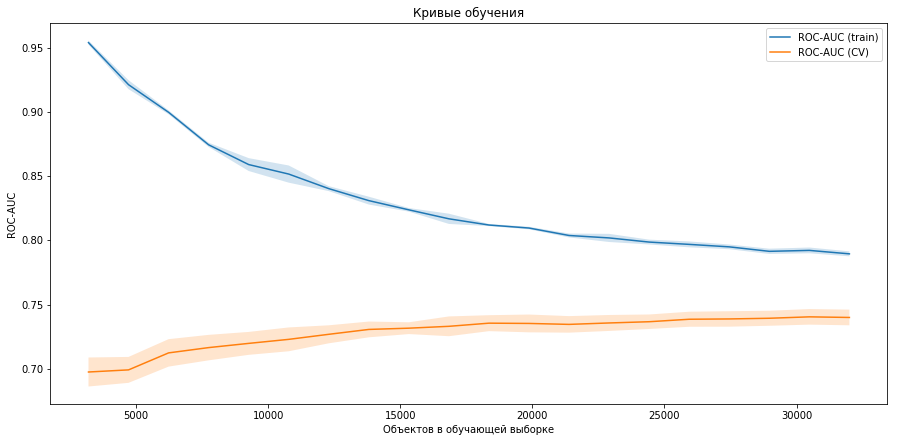

In [7]:
auc_train_mean = np.mean(auc_train, axis=1)
auc_train_std = np.std(auc_train, axis=1)
auc_test_mean = np.mean(auc_test, axis=1)
auc_test_std = np.std(auc_test, axis=1)
plt.figure(figsize=(15,7))
plt.plot(train_size, auc_train_mean, label='ROC-AUC (train)')
plt.plot(train_size, auc_test_mean, label='ROC-AUC (CV)')
plt.fill_between(train_size, auc_train_mean-auc_train_std, auc_train_mean+auc_train_std, alpha=0.2)
plt.fill_between(train_size, auc_test_mean-auc_test_std, auc_test_mean+auc_test_std, alpha=0.2)
plt.title('Кривые обучения')
plt.xlabel('Объектов в обучающей выборке')
plt.ylabel('ROC-AUC')
plt.legend()
plt.show();

Для обучения возьмем 80% от всей выборки.

2\. Часто несбалансированные по классам выборки приводят к различным проблемам при обучении моделей. Давайте попробуем по-разному обработать выборку, поиграть с распределением объектов по классам и сделать выводы о том, как соотношение классов влияет на качество модели.

2.1\. Задайте веса объектам так, чтобы соотношение классов с учетом весов объектов изменилось. Попробуйте не менее трёх различных вариантов весов. Меняются ли результаты классификации? Как это сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

In [8]:
train, test, y_train, y_test = train_test_split(df.drop(target, axis=1), df[target],
                                                stratify=df[target], test_size=0.2, random_state=42)
train[target] = y_train.values
test[target] = y_test.values

In [9]:
accuracy = []
pr_auc = []
roc_auc = []
f1 = []
precision = []
recall = []
lift = []

xgb2 = XGBClassifier(objective= 'binary:logistic', nthread=4, seed=27)

ws = np.linspace(0.1, 10, 50)

for w in ws:
    xgb2.fit(train[predictors], train[target], sample_weight=y_train.apply(lambda x: w if x==1 else 1).values)
    test_predictions = xgb2.predict(test[predictors])
    test_predprob = xgb2.predict_proba(test[predictors])[:,1]
    
    accuracy.append(metrics.accuracy_score(test[target].values, test_predictions))
    pr_auc.append(metrics.average_precision_score(test[target], test_predictions))
    roc_auc.append(metrics.roc_auc_score(test[target], test_predprob))
    f1.append(metrics.f1_score(test[target], test_predictions))
    precision.append(metrics.precision_score(test[target], test_predictions))
    recall.append(metrics.recall_score(test[target], test_predictions))
    lift.append(lift_score(test[target], test_predictions))

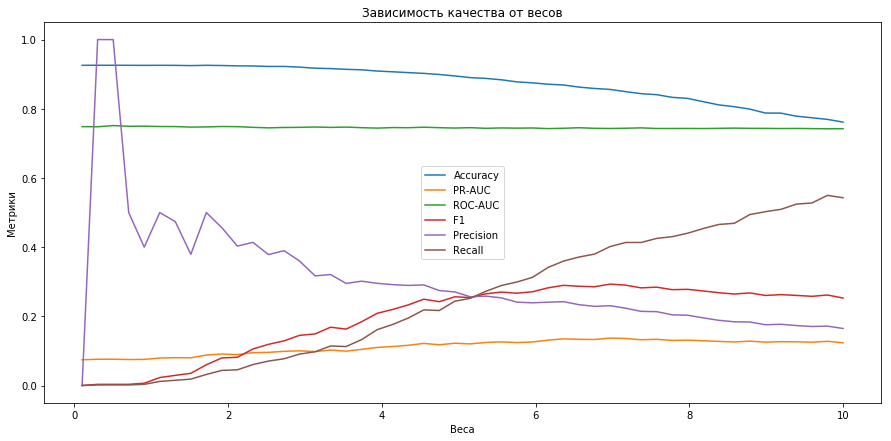

In [10]:
plt.figure(figsize=(15,7))
plt.plot(ws, accuracy, label='Accuracy')
plt.plot(ws, pr_auc, label='PR-AUC')
plt.plot(ws, roc_auc, label='ROC-AUC')
plt.plot(ws, f1, label='F1')
plt.plot(ws, precision, label='Precision')
plt.plot(ws, recall, label='Recall')
#plt.plot(ws, lift, label='Lift')
plt.title('Зависимость качества от весов')
plt.xlabel('Веса')
plt.ylabel('Метрики')
plt.legend()
plt.show();

Наиболее оптимальным с точки зрения качества выглядит вариант с весом 7

2.2\. Примените к выборке технологию undersampling: для этого нужно убрать из обучения некоторое количество объектов большего класса таким образом, чтобы соотношение классов изменилось. Попробуйте не менее трёх различных вариантов undersampling (варианты могут отличаться как по количество отфильтрованных объектов, так и по принципу выборка объектов для отсеивания из выборки). Меняются ли результаты классификации? Как это сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

In [11]:
from imblearn.pipeline import make_pipeline
from imblearn.under_sampling import RandomUnderSampler, AllKNN, NeighbourhoodCleaningRule
from imblearn.over_sampling import SMOTE

In [12]:
imputer = Imputer(missing_values=np.NAN, axis=1)
samplers = {
    'RandomUnderSampler': RandomUnderSampler(random_state=42),
    'AllKNN': AllKNN(random_state=42, allow_minority=True),
    'NeighbourhoodCleaningRule': NeighbourhoodCleaningRule(random_state=42),
    'SMOTE': SMOTE(random_state=42) # oversampling тоже попробуем
}

xgb3 = XGBClassifier(objective= 'binary:logistic', nthread=4, seed=27)

accuracy = []
pr_auc = []
roc_auc = []
f1 = []
precision = []
recall = []
lift = []

for sampler in samplers:
    clf = make_pipeline(imputer, samplers[sampler], xgb3)
    clf.fit(train[predictors], train[target])
    test_predictions = clf.predict(test[predictors])
    test_predprob = clf.predict_proba(test[predictors])[:,1]
    
    accuracy.append(metrics.accuracy_score(test[target].values, test_predictions))
    pr_auc.append(metrics.average_precision_score(test[target], test_predictions))
    roc_auc.append(metrics.roc_auc_score(test[target], test_predprob))
    f1.append(metrics.f1_score(test[target], test_predictions))
    precision.append(metrics.precision_score(test[target], test_predictions))
    recall.append(metrics.recall_score(test[target], test_predictions))
    lift.append(lift_score(test[target], test_predictions))

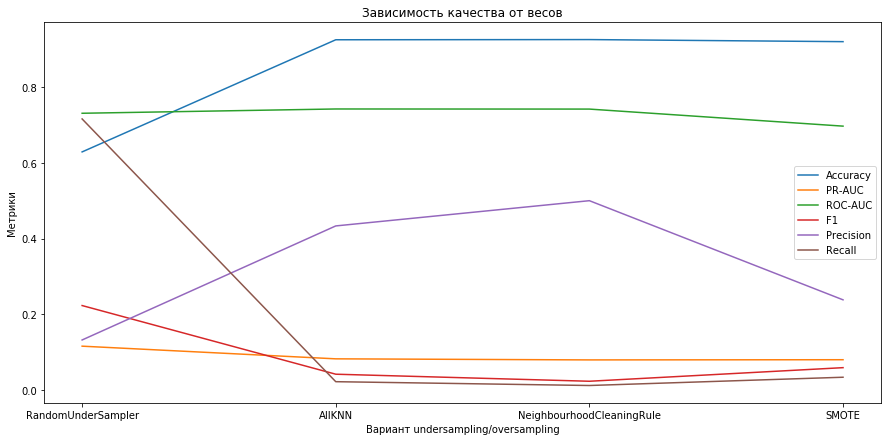

In [13]:
plt.figure(figsize=(15,7))
plt.plot(samplers.keys(), accuracy, label='Accuracy')
plt.plot(samplers.keys(), pr_auc, label='PR-AUC')
plt.plot(samplers.keys(), roc_auc, label='ROC-AUC')
plt.plot(samplers.keys(), f1, label='F1')
plt.plot(samplers.keys(), precision, label='Precision')
plt.plot(samplers.keys(), recall, label='Recall')
#plt.plot(samplers.keys(), lift, label='Lift')
plt.title('Зависимость качества от весов')
plt.xlabel('Вариант undersampling/oversampling')
plt.ylabel('Метрики')
plt.legend()
plt.show();

Наиболее оптимальным с точки зрения качества выглядит выглядит вариант RandomUnderSampler

3\. Теперь перейдем к работе с признаками. Ранее вы реализовали несколько стратегий для обработки пропущенных значений. Сравните эти стратегии между собой с помощью оценки качества моделей кросс-валидации, построенных на датасетах с использованием различных стратегий. Как обработка пропущенных значений сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

In [14]:
def modelfit(alg, dtrain, dtest, predictors, useTrainCV=True, cv_folds=5, early_stopping_rounds=100):
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds, stratified=True,
            metrics='auc', early_stopping_rounds=early_stopping_rounds, verbose_eval=False, seed=27)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    alg.fit(dtrain[predictors], dtrain[target], early_stopping_rounds=early_stopping_rounds, verbose=False,
            eval_metric='auc', eval_set=[(dtrain[predictors], dtrain[target]), (dtest[predictors], dtest[target])])
        
    test_predictions = alg.predict(dtest[predictors])
    test_predprob = alg.predict_proba(dtest[predictors])[:,1]
        
    print("Accuracy : %.4g" % metrics.accuracy_score(dtest[target].values, test_predictions))
    print("PR-AUC: %.4g" % metrics.average_precision_score(dtest[target], test_predictions))
    print("ROC-AUC: %.4g" % metrics.roc_auc_score(dtest[target], test_predprob))
    print("F1: %.4g" % metrics.f1_score(dtest[target], test_predictions))
    print("Preсision: %.4g" % metrics.precision_score(dtest[target], test_predictions))
    print("Recall: %.4g" % metrics.recall_score(dtest[target], test_predictions))
    print("Lift : %.4g" % lift_score(dtest[target], test_predictions))

In [15]:
xgb4 = XGBClassifier(objective= 'binary:logistic', nthread=4, seed=27)

print('As is')
modelfit(xgb4, train, test, predictors)
print('Mean')
imputer = Imputer(strategy='mean', missing_values=np.NAN, axis=1)
modelfit(xgb4, pd.DataFrame(imputer.fit_transform(train), columns=train.columns),
         pd.DataFrame(imputer.transform(test), columns=train.columns), predictors)
print('Median')
imputer = Imputer(strategy='median', missing_values=np.NAN, axis=1)
modelfit(xgb4, pd.DataFrame(imputer.fit_transform(train), columns=train.columns),
         pd.DataFrame(imputer.transform(test), columns=train.columns), predictors)
print('Most_frequent')
imputer = Imputer(strategy='most_frequent', missing_values=np.NAN, axis=1)
modelfit(xgb4, pd.DataFrame(imputer.fit_transform(train), columns=train.columns),
         pd.DataFrame(imputer.transform(test), columns=train.columns), predictors)
print('Zero')
modelfit(xgb4, train.fillna(0), test.fillna(0), predictors)

As is
Accuracy : 0.9257
PR-AUC: 0.07637
ROC-AUC: 0.7484
F1: 0.006689
Preсision: 0.6667
Recall: 0.003361
Lift : 8.964
Mean
Accuracy : 0.9257
PR-AUC: 0.07637
ROC-AUC: 0.7454
F1: 0.006689
Preсision: 0.6667
Recall: 0.003361
Lift : 8.964
Median
Accuracy : 0.9254
PR-AUC: 0.07525
ROC-AUC: 0.7393
F1: 0.006656
Preсision: 0.3333
Recall: 0.003361
Lift : 4.482
Most_frequent
Accuracy : 0.9256
PR-AUC: 0.07509
ROC-AUC: 0.743
F1: 0.00335
Preсision: 0.5
Recall: 0.001681
Lift : 6.723
Zero
Accuracy : 0.9256
PR-AUC: 0.07509
ROC-AUC: 0.743
F1: 0.00335
Preсision: 0.5
Recall: 0.001681
Lift : 6.723


Наиболее оптимальным с точки зрения качества выглядит вариант без дополнительной обработки пропущенных значений.

4\. Также вы уже реализовали несколько стратегий для обработки категориальных признаков. Сравните эти стратегии между собой с помощью оценки качества моделей по кросс-валидации, построенных на датасетах с использованием различных стратегий. Как обработка категориальных признаков сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

In [16]:
df = pd.read_csv('orange_small_churn_train_data.csv')
df.loc[df[target]==-1, target] = 0
train, test, y_train, y_test = train_test_split(df.drop(target, axis=1), df[target],
                                                stratify=df[target], test_size=0.2, random_state=42)
train[target] = y_train.values
test[target] = y_test.values

In [17]:
import category_encoders as ce

xgb5 = XGBClassifier(objective= 'binary:logistic', nthread=4, seed=27)

print('Label encoder') # см. выше As is
print('Accuracy : 0.9149')
print('PR-AUC: 0.1061')
print('ROC-AUC: 0.7487')
print('F1: 0.1745')
print('Preсision: 0.3261')
print('Recall: 0.121')
print('Lift : 4.209')
print('Leave-One-Out Encoder')
encoder = ce.LeaveOneOutEncoder(cols=list(cat_columns), random_state=42)
modelfit(xgb5, encoder.fit_transform(train, train[target]), encoder.transform(test), predictors)
print('Randomized Leave-One-Out Encoder')
encoder = ce.LeaveOneOutEncoder(cols=list(cat_columns), randomized=True, random_state=42)
modelfit(xgb5, encoder.fit_transform(train, train[target]), encoder.transform(test), predictors)
print('Target Encoder')
encoder = ce.TargetEncoder(cols=list(cat_columns))
modelfit(xgb5, encoder.fit_transform(train, train[target]), encoder.transform(test), predictors)

Label encoder
Accuracy : 0.9149
PR-AUC: 0.1061
ROC-AUC: 0.7487
F1: 0.1745
Preсision: 0.3261
Recall: 0.121
Lift : 4.209
Leave-One-Out Encoder
Accuracy : 0.9066
PR-AUC: 0.07695
ROC-AUC: 0.5791
F1: 0.06742
Preсision: 0.1311
Recall: 0.04538
Lift : 1.762
Randomized Leave-One-Out Encoder
Accuracy : 0.9066
PR-AUC: 0.07695
ROC-AUC: 0.5791
F1: 0.06742
Preсision: 0.1311
Recall: 0.04538
Lift : 1.762
Target Encoder
Accuracy : 0.9159
PR-AUC: 0.07757
ROC-AUC: 0.5813
F1: 0.0561
Preсision: 0.1695
Recall: 0.03361
Lift : 2.279


Наиболее оптимальным с точки зрения качества выглядит выглядит вариант Label encoder

5\. Все ли признаки оказались полезными для построения моделей? Проведите процедуру отбора признаков, попробуйте разные варианты отбора (обратите внимание на модуль `sklearn.feature_selection`). Например, можно выбрасывать случайные признаки или строить отбор на основе l1-регуляризации - отфильтровать из обучения признаки, которые получат нулевой вес при построении регрессии с l1-регуляризацией (`sklearn.linear_model.Lasso`). И всегда можно придумать что-то своё=) Попробуйте как минимум 2 различные стратегии, сравните результаты. Помог ли отбор признаков улучшить качество модели? Поясните свой ответ.

In [18]:
df = pd.read_csv('orange_small_churn_train_data.csv')
df[cat_columns] = df[cat_columns].astype(np.str)
df.loc[df[target]==-1, target] = 0
encoder = MultiColumnLabelEncoder(columns=cat_columns)
df = encoder.fit_transform(df)
train, test, y_train, y_test = train_test_split(df.drop(target, axis=1), df[target],
                                                stratify=df[target], test_size=0.2, random_state=42)
train[target] = y_train.values
test[target] = y_test.values

In [19]:
from sklearn.svm import LinearSVC
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_val_score
from imblearn.pipeline import Pipeline 

selectors = [ 
    ('Lasso_0', Lasso(alpha=0, random_state=42)),
    ('Lasso_0.0001', Lasso(alpha=0.0001, random_state=42)),
    ('Lasso_0.0005', Lasso(alpha=0.0005, random_state=42)),
    ('Lasso_0.001', Lasso(alpha=0.001, random_state=42)),
    ('Lasso_0.005', Lasso(alpha=0.005, random_state=42)),
    ('Lasso_0.01', Lasso(alpha=0.01, random_state=42)),
    ('SVC_0.0001', LinearSVC(C=0.0001, penalty="l1", dual=False, random_state=42)),
    ('SVC_0.0005', LinearSVC(C=0.0005, penalty="l1", dual=False, random_state=42)),
    ('SVC_0.001', LinearSVC(C=0.001, penalty="l1", dual=False, random_state=42)),
    ('SVC_0.005', LinearSVC(C=0.005, penalty="l1", dual=False, random_state=42)),
    ('SVC_0.01', LinearSVC(C=0.01, penalty="l1", dual=False, random_state=42))
]

xgb6 = XGBClassifier(objective= 'binary:logistic', nthread=4, seed=27)

for selector_name, selector in selectors:
    clf = Pipeline([
        ('imputer', Imputer(strategy='mean', missing_values=np.NAN, axis=1)),
        (selector_name, SelectFromModel(selector)),
        ('xgb', xgb6)
    ])
    cv_score = cross_val_score(clf, train[predictors], train[target], cv=5 , scoring='roc_auc')
    print(selector_name, '%.4f' % np.mean(cv_score))

Lasso_0 0.6646
Lasso_0.0001 0.6653
Lasso_0.0005 0.6612
Lasso_0.001 0.6583
Lasso_0.005 0.6264
Lasso_0.01 0.6260
SVC_0.0001 0.6219
SVC_0.0005 0.6256
SVC_0.001 0.6325
SVC_0.005 0.6523
SVC_0.01 0.6587


Наиболее оптимальным с точки зрения качества выглядит выглядит вариант без отбора признаков (признаки уже были отобраны в задании недели 4).

6\. Подберите оптимальные параметры модели. Обратите внимание, что в зависимости от того, как вы обработали исходные данные, сделали ли балансировку классов, сколько объектов оставили в обучающей выборке и др. оптимальные значения параметров могут меняться. Возьмите наилучшее из ваших решений на текущий момент и проведите процедуру подбора параметров модели (обратите внимание на `sklearn.model_selection.GridSearchCV`) Как подбор параметров повлиял на качество модели?

In [20]:
# вручную подберем гиперпараметры модели на кросс-валидации
xgb7 = XGBClassifier(learning_rate =0.1, n_estimators=200, max_depth=3, min_child_weight=3,
                     gamma=0, subsample=0.9, colsample_bytree=0.68, reg_alpha=0, scale_pos_weight=4,
                     sample_weight=train[target].apply(lambda x: 7 if x==1 else 1).values,
                     objective= 'binary:logistic', nthread=4, seed=27)
modelfit(xgb7, train, test, predictors)

Accuracy : 0.916
PR-AUC: 0.111
ROC-AUC: 0.7506
F1: 0.1962
Preсision: 0.3402
Recall: 0.1378
Lift : 4.575


7\. Предложите методику оценки того, какие признаки внесли наибольший вклад в модель (например, это могут быть веса в случае регрессии, а также большое количество моделей реализуют метод `feature_importances_` - оценка важности признаков). На основе предложенной методики проанализируйте, какие признаки внесли больший вклад в модель, а какие меньший?

In [21]:
# среди значимых признаков есть как вещесттвенные, так и категориальные признаки
imp = pd.DataFrame(xgb7.feature_importances_, index=train[predictors].columns, columns=['importance'])
imp.sort_values(by='importance', ascending=False).head(15)

,importance
Var126,0.102919
Var189,0.058372
Var113,0.056836
Var218,0.050691
Var81,0.046083
Var57,0.041475
Var74,0.032258
Var73,0.029186
Var217,0.026114
Var28,0.026114


In [22]:
# 125 признака оказались с нулевой важностью для модели
# + в задании недели 4 были исключены признаки, которые ухудшали качество модели
print(imp[imp['importance']==0].shape[0])
imp.sort_values(by='importance', ascending=True).head(15)

125


,importance
Var1,0.0
Var121,0.0
Var122,0.0
Var124,0.0
Var127,0.0
Var128,0.0
Var130,0.0
Var131,0.0
Var135,0.0
Var138,0.0


8\. Напоследок давайте посмотрим на объекты. На каких объектах достигается наибольшая ошибка классификации? Есть ли межу этими объектами что-то общее? Видны ли какие-либо закономерности? Предположите, почему наибольшая ошибка достигается именно на этих объектах. В данном случае "наибольшую" ошибку можно понимать как отнесение объекта с чужому классу с большой долей уверенности (с высокой вероятностью).

In [23]:
test['preds'] = xgb7.predict_proba(test[predictors])[:,1]
test['mae'] = test.apply(lambda x: np.abs(x.labels-x.preds), axis=1)
test[test.mae > 0.9]

,ID,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,...,Var224,Var225,Var226,Var227,Var228,Var229,Var230,labels,preds,mae
24260,24260,NaN,NaN,NaN,NaN,NaN,4039.0,0.0,NaN,NaN,...,1,1,8,2,8,1,NaN,1,0.067024,0.932976
19207,19207,NaN,NaN,NaN,NaN,NaN,840.0,7.0,NaN,NaN,...,1,1,4,3,25,0,NaN,1,0.098708,0.901292
24934,24934,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0,2,7,2,8,2,NaN,1,0.081526,0.918474
21351,21351,NaN,NaN,NaN,NaN,NaN,2660.0,7.0,NaN,NaN,...,1,2,7,2,8,2,NaN,1,0.078049,0.921951
4012,4012,NaN,NaN,NaN,NaN,NaN,2226.0,7.0,NaN,NaN,...,1,1,7,3,25,1,NaN,1,0.064105,0.935895
2040,2040,NaN,NaN,NaN,NaN,NaN,833.0,7.0,NaN,NaN,...,1,2,12,2,8,2,NaN,1,0.081104,0.918896
38587,38587,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0,2,18,2,8,2,NaN,1,0.096057,0.903943
20055,20055,NaN,NaN,NaN,NaN,NaN,308.0,0.0,NaN,NaN,...,1,2,14,2,8,2,NaN,1,0.094586,0.905414
34104,34104,NaN,NaN,NaN,NaN,NaN,1750.0,7.0,NaN,NaN,...,1,1,10,2,8,0,NaN,1,0.058285,0.941715
7416,7416,NaN,NaN,NaN,NaN,NaN,651.0,7.0,NaN,NaN,...,1,0,9,2,2,1,NaN,1,0.071458,0.928542


Среди объектов, на котрых достигается наибольшая ошибка классификации, много пропущенных значений, поэтому наибольшая ошибка достигается именно на этих объектах.

9\. По итогам проведенных экспериментов постройте финальную решение - модель с наилучшим качеством. Укажите, какие преобразования данных, параметры и пр. вы выбрали для построения финальной модели.

In [24]:
# используем Label Encoder и вес 7 для объектов положительного класса.
# Undersampling не используем, т.к. оно требует обработки пропущенных значений, а обработка сничает качество.
# Автоматический оттбор приззнаков не исполььзуем, исключим из выборки только те признаки, которые понимают качество модели.
xgb8 = XGBClassifier(learning_rate =0.1, n_estimators=200, max_depth=3, min_child_weight=3,
                     gamma=0, subsample=0.9, colsample_bytree=0.68, reg_alpha=0, scale_pos_weight=4,
                     sample_weight=train[target].apply(lambda x: 7 if x==1 else 1).values,
                     objective= 'binary:logistic', nthread=4, seed=27)
modelfit(xgb8, train, test, predictors)

Accuracy : 0.916
PR-AUC: 0.111
ROC-AUC: 0.7506
F1: 0.1962
Preсision: 0.3402
Recall: 0.1378
Lift : 4.575


10\. Подумайте, можно ли еще улучшить модель? Что для этого можно сделать? 

- Можно попробовать другие способы обработки данных и извлечения приззнаков (например, полиномиальные признаки)
- Можно попробовать тонкую настройку других моделей
- Можно попробовать ансамбли моделей